# Capillary theory

I propose a theory to explain whether we observe dimple or not in a thin liquid film. The core idea is the dimple is unstable because surface tension always has a tendency to smooth it out. To observe it, the surface tension induced flow has to be sufficiently small, so that the dimple stays longer. 

The dimple formation around a beet slice has two steps:

1. Initial dimple formation due to the suction flow of the beet slice;
2. The smooth-out due to the surface tension induced flow. 

In this notebook, I will model these two steps based on the physical picture depicted above. A simple numerical solution will be presented.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import matplotlib
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams['mathtext.fontset'] = 'stix'

C:\Users\zl948\AppData\Local\Temp\ipykernel_36032\951329748.py:91: RuntimeWarning: invalid value encountered in divide
  normals /= np.linalg.norm(normals, axis=1)[:, None]


Number of time steps in solution: 100
Expected number of time steps: 100
Solver message: The solver successfully reached the end of the integration interval.


Text(0, 0.5, 'Total Volume')

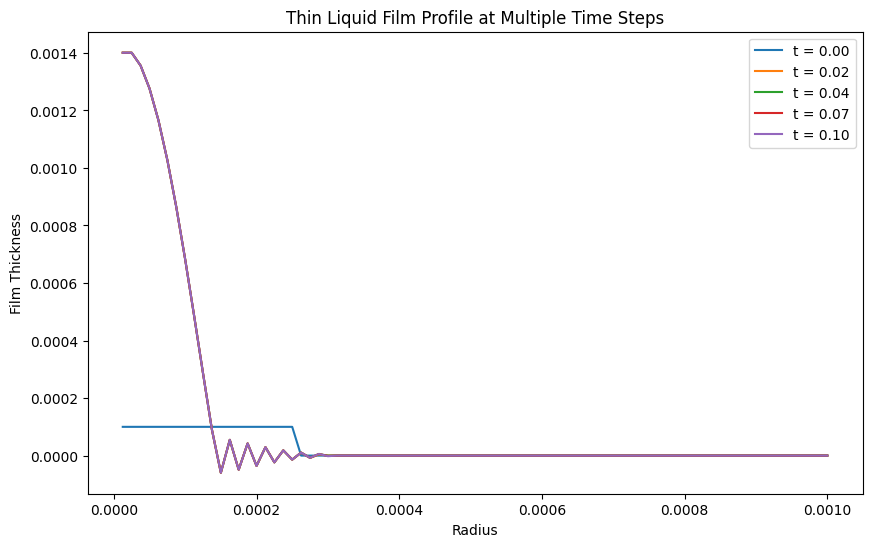

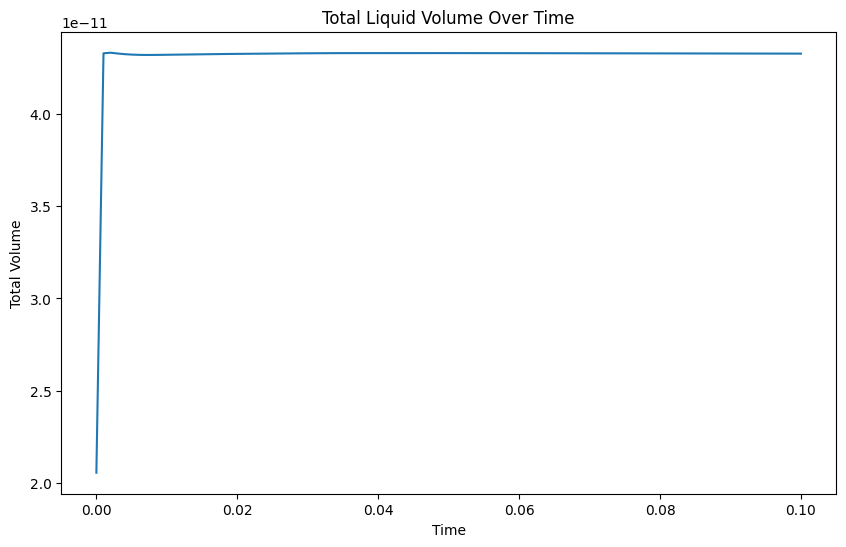

In [205]:
# Define parameters
sigma = 0.072  # Surface tension (N/m)
mu = 0.01    # Viscosity (Pa.s)
T = .1    # Total simulation time (s)
R = 1e-3         # Radius of the domain (m)
N = 80      # Number of radial grid points
rho = 997     # Density of water (kg/m^3)
g = 9.8       # Gravitational acceleration (m/s^2)
r = np.linspace(R/N, R, N)  # Radial coordinate
dx = r[1] - r[0]  # Radial step size
h0 = np.ones_like(r)*1e-4  # Initial film thickness profile
h0[-60:] = 0
p_list, phi_list, phi0_list, t_list = [], [], [], []

def film_drainage(t, y, r, R, rho, g, mu, sigma):
    cx
    h = y

    dr = (r[2:] - r[:-2]) / 2
    
    p = YL_equation(h, r, sigma, R)

    # detect contact line
    cl = np.argmax(h[10:] < 1e-6) + 10
    
    # enforce 0 pressure after contact line
    p[cl:] = 0
    # h[cl:] = 0
    
    # set the 4 points around the contact line as the marker for immersed boundary method
    Xk0 = r[:4]
    Yk0 = h[:4]
    Xk = r[cl-2:cl+2]
    Yk = h[cl-2:cl+2]

    # apply contact angle force, 30 degrees contact angle
    Fk = apply_contact_angle_force(Xk, Yk, np.pi/3)
    # Fk0 = apply_contact_angle_force(Xk0, Yk0, np.pi/20)

    # distribute force to the grid points with a delta function
    f_grid = np.zeros(N)  # Force field on the grid
    for k in range(len(Xk)):
        f_grid += delta_function(Xk[k], r) * Fk[k]
    # f_grid0 = np.zeros((N, 2))  # Force field on the grid
    # for k in range(len(Xk0)):
    #     f_grid0 += delta_function(Xk0[k], r) * Fk0[k]
    
    # convert the force field to the corresponding potential field
    phi = np.zeros(N)
    # phi0 = np.zeros(N)
    for i in range(1, N):
        phi[i] = phi[i-1] - dx * f_grid[i] 
        # phi0[i] = phi0[i-1] - dx * f_grid0[i, 0]
        
    # calculate the effective pressure field
    peff = p - phi #- phi0

    # save pressure data for debugging
    t_list.append(t)
    p_list.append(p)
    phi_list.append(phi)
    # phi0_list.append(phi0)
    
    dhdt = np.zeros(h.shape)
    rh3 = r * h**3
    dhdt[1:-1] = 1 / (12 * mu * r[1:-1]) * ((rh3[2:] - rh3[:-2]) * (peff[2:] - peff[:-2]) + 4 * rh3[1:-1] * (peff[2:] - 2 * peff[1:-1] + peff[:-2])) / dr**2
    dhdt[-1] = 0
    dhdt[0] = dhdt[1]

    return dhdt

def YL_equation(h, r, sigma, R):
    dr = (r[2:] - r[:-2]) / 2
    p = np.zeros_like(h)
    p[1:-1] = 2 * sigma / R - sigma / np.abs(r[1:-1]) * (h[2:] - h[:-2]) / dr / 2 - sigma * (h[2:] - 2 * h[1:-1] + h[:-2]) / dr**2
    p[0] = p[1]
    p[-1] = 0
    return p

def compute_normal(Xk, Yk):
    # Calculate the normal vector at each marker (simplified)
    # Use finite differences or interpolation
    # Example: return normal vector perpendicular to the interface
    normals = np.zeros((len(Xk), 2))
    normals[1:-1, 0] = (Yk[2:] - Yk[:-2]) / (Xk[2:] - Xk[:-2])
    normals[1:-1, 1] = -1
    normals /= np.linalg.norm(normals, axis=1)[:, None]
    normals[0] = normals[1]
    normals[-1] = normals[-2]
    
    return normals

def apply_contact_angle_force(Xk, Yk, theta_c, kappa=1.0e0):
    # Calculate the target normal vector based on theta_c
    normals = compute_normal(Xk, Yk)
    n_target = np.array([np.sin(theta_c), -np.cos(theta_c)])  # Example for horizontal substrate

    # Apply spring-like force to enforce the contact angle
    Fk = -kappa * (normals - n_target)
    return Fk[:, 0]

def delta_function(Xk, r):
    # Calculate the delta function at each grid point
    Nx = len(r)
    delta_sigma = dx * 3

    # Initialize delta function array
    delta = np.zeros(Nx)
    
    # Compute Gaussian function centered at Xk
    gaussian = np.exp(-((Xk - r)**2) / (2 * delta_sigma**2))
    
    # Normalize the delta function to ensure it integrates to 1 over the grid
    normalization_factor = np.trapz(gaussian * r, r)
    delta = gaussian / normalization_factor
    
    return delta


def compute_contact_angle(r, h):
    # Calculate the contact angle based on the film thickness profile
    # Example: use the slope of the interface near the contact line
    cl = np.argmax(h[10:] < 1e-6) + 10
    angle = - np.arctan((h[cl] - h[cl-5]) / (r[cl] - r[cl-5]))
    return np.degrees(angle)

# Solve the PDE using solve_ivp with the BDF method
t_eval = np.linspace(0, T, 100)
solution = solve_ivp(film_drainage, [0, T], h0, method='BDF', t_eval=t_eval, args=(r, R, rho, g, mu, sigma), atol=1e-6, rtol=1e-6)  # BDF method is suitable for stiff problems

# Debugging information
print(f"Number of time steps in solution: {solution.y.shape[1]}")
print(f"Expected number of time steps: {len(t_eval)}")
print(f"Solver message: {solution.message}")

# Check if the solution has the expected number of time steps
if solution.y.shape[1] != len(t_eval):
    raise ValueError(f"Expected {len(t_eval)} time steps, but got {solution.y.shape[1]}")

# Plot the film thickness profile at multiple time steps on the same axis
time_steps = [0, 20, 40, 70, 99] # Indices of the time steps to visualize
fig, ax = plt.subplots(figsize=(10, 6))

for i in time_steps:
    if i < solution.y.shape[1]:
        ax.plot(r, solution.y[:, i], label=f't = {t_eval[i]:.2f}')
    else:
        ax.plot(r, solution.y[:, -1], label=f't = {t_eval[i]:.2f} (out of bounds)')

ax.set_title('Thin Liquid Film Profile at Multiple Time Steps')
ax.set_xlabel('Radius')
ax.set_ylabel('Film Thickness')
ax.legend()

# Compute the total liquid volume over time
total_volume = 2 * np.pi * np.trapz(np.outer(r, np.ones(len(t_eval))) * solution.y, r, axis=0)

# Plot the total liquid volume over time
fig, ax2 = plt.subplots(figsize=(10, 6))
ax2.plot(t_eval, total_volume)
ax2.set_title('Total Liquid Volume Over Time')
ax2.set_xlabel('Time')
ax2.set_ylabel('Total Volume')

Slope (m): -0.1609636766401085
Contact Angle (θ): 9.14 degrees


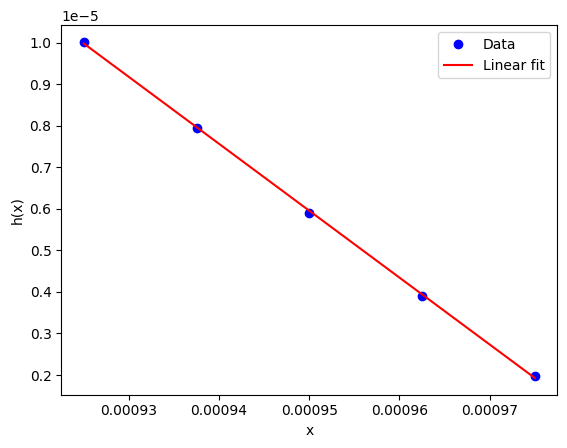

In [202]:
h = solution.y[:, -1]
cl = np.argmax(h[10:] < 1e-6) + 10
x = r[cl-5:cl]
y = h[cl-5:cl]
# x = r[:5]
# y = h[:5]

# Fit a linear model to the data
coefficients = np.polyfit(x, y, 1)  # 1 indicates linear fit
m = coefficients[0]  # slope

# Calculate the contact angle in radians
theta_rad = -np.arctan(m)

# Convert to degrees for readability
theta_deg = np.degrees(theta_rad)

print(f"Slope (m): {m}")
print(f"Contact Angle (θ): {theta_deg:.2f} degrees")

# Plotting the data and the linear fit
plt.plot(x, y, 'bo', label='Data')
plt.plot(x, np.polyval(coefficients, x), 'r-', label='Linear fit')
plt.xlabel('x')
plt.ylabel('h(x)')
plt.legend()
plt.show()

In [206]:
t = np.array(t_list)
p = np.array(p_list)
phi = np.array(phi_list)
phi0 = np.array(phi0_list)

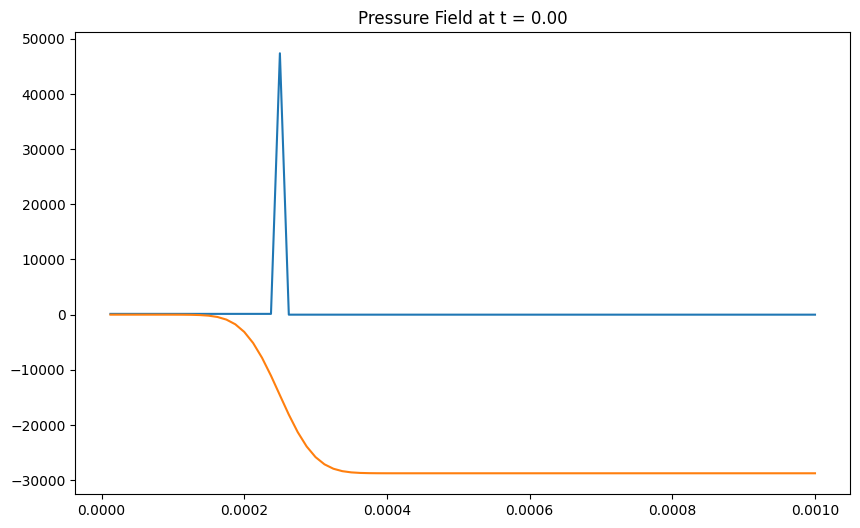

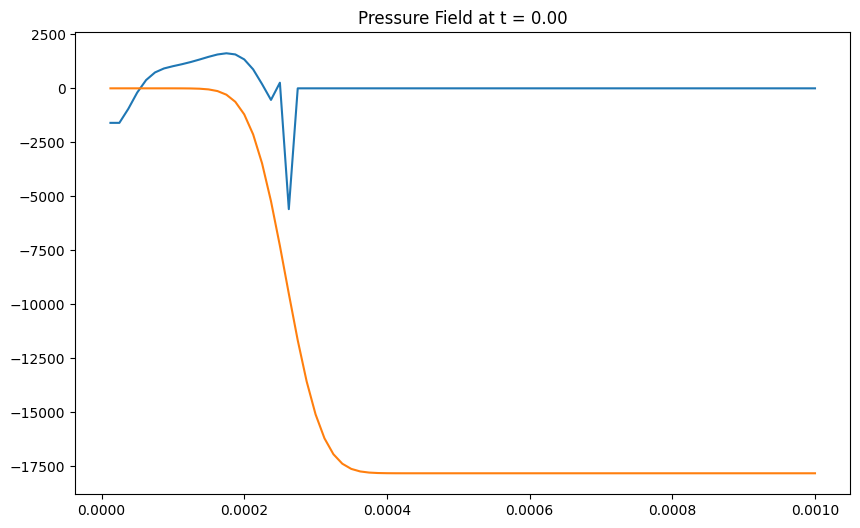

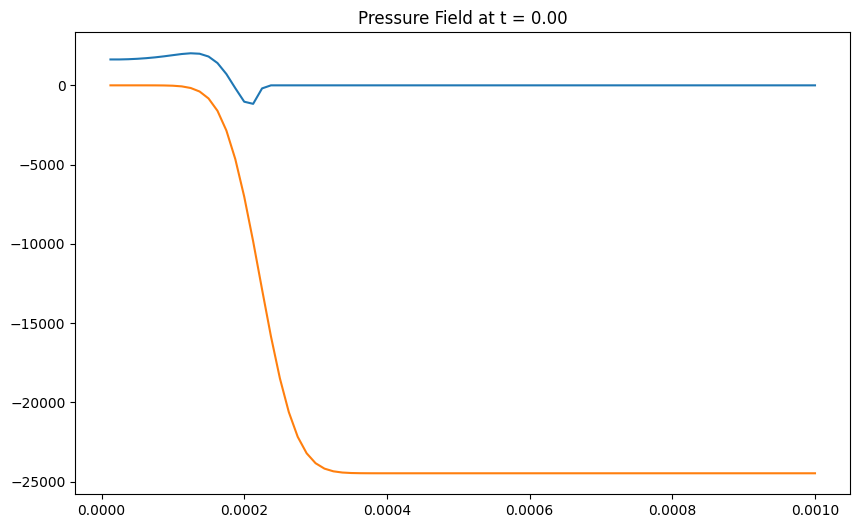

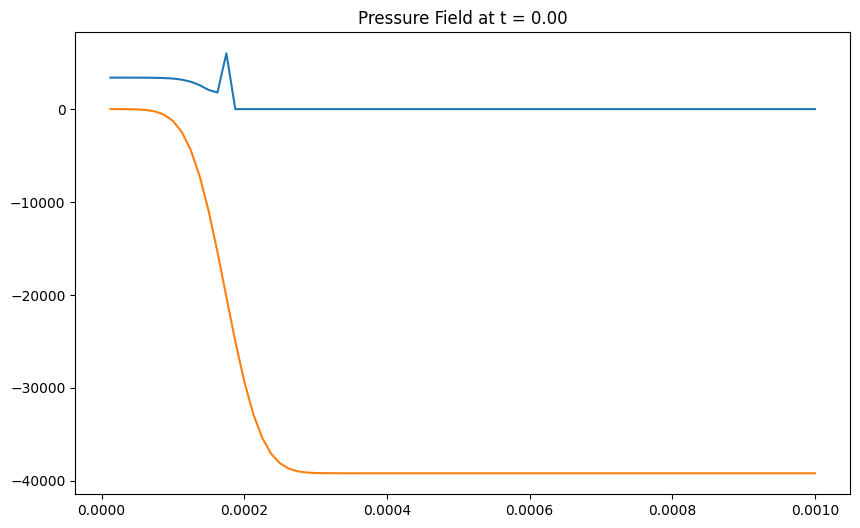

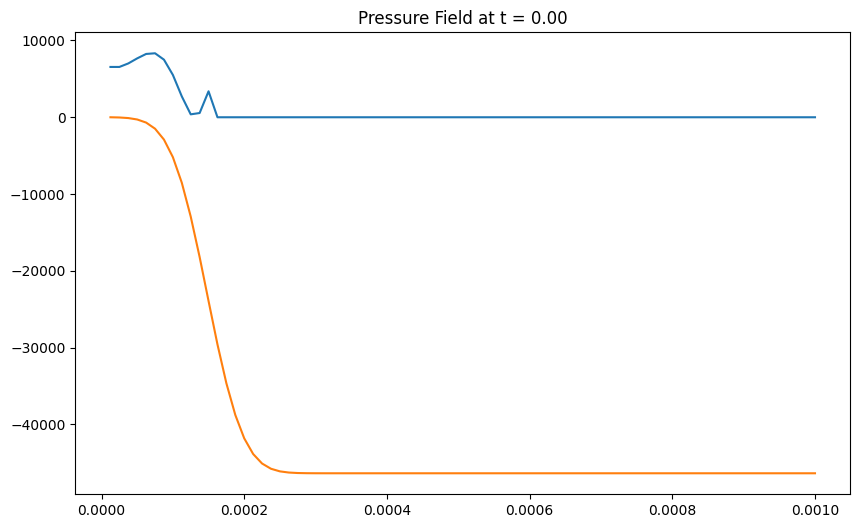

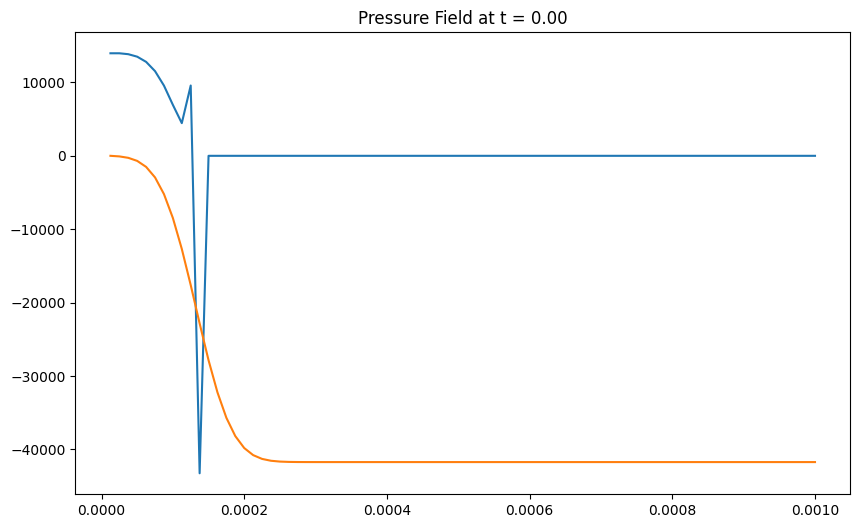

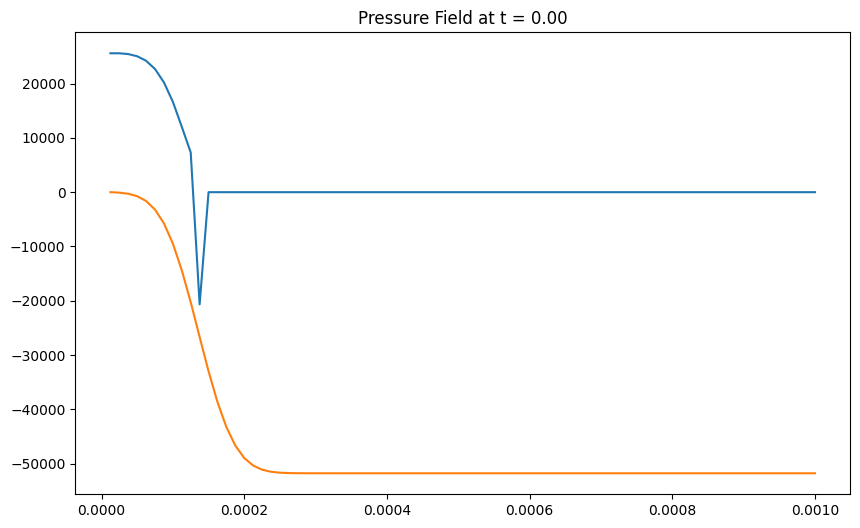

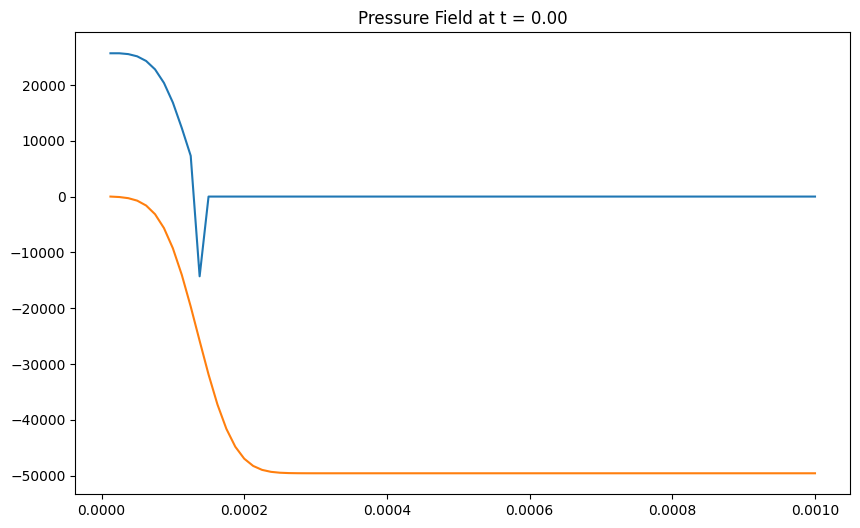

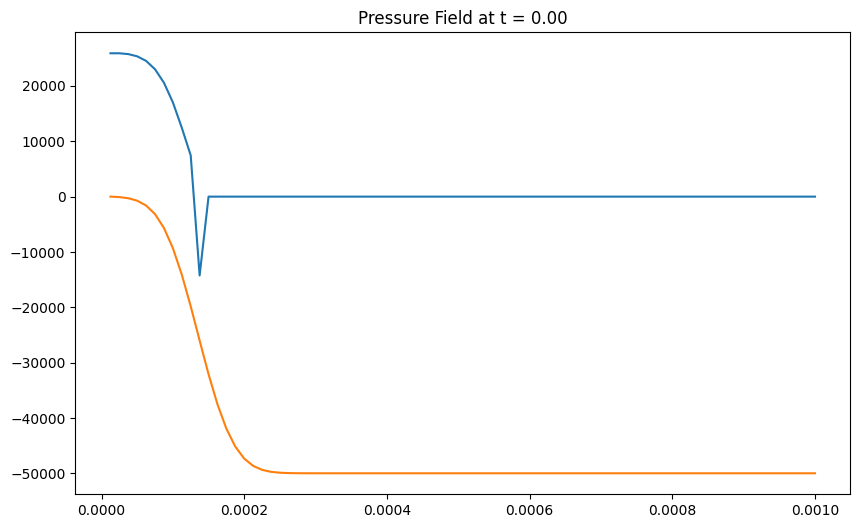

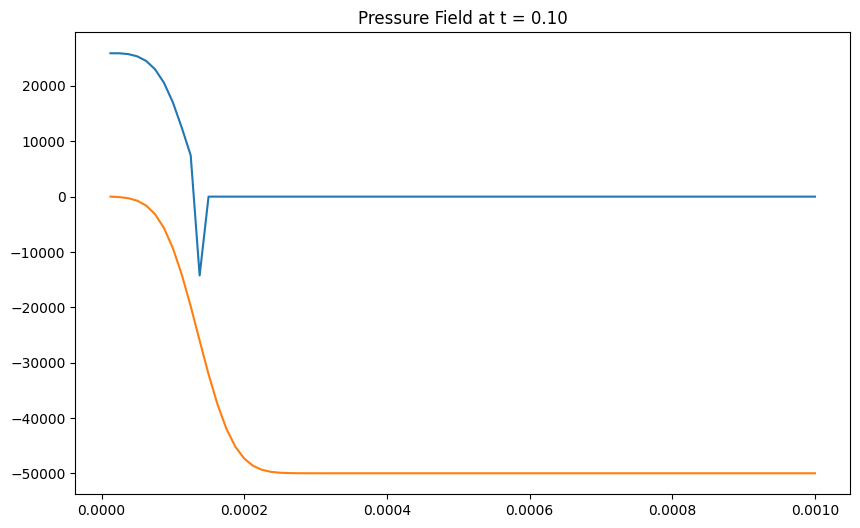

In [207]:
# plot the pressure fields at 10 time steps

time_steps = np.linspace(0, len(p_list)-1, 10, dtype=int)
for i in time_steps:
    fig, ax3 = plt.subplots(figsize=(10, 6))
    ax3.plot(r, p[i])
    ax3.plot(r, phi[i])
    # ax3.plot(r, phi0[i])
    # ax3.plot(r, p[i] - phi[i] - phi0[i])
    ax3.set_title(f'Pressure Field at t = {t[i]:.2f}')


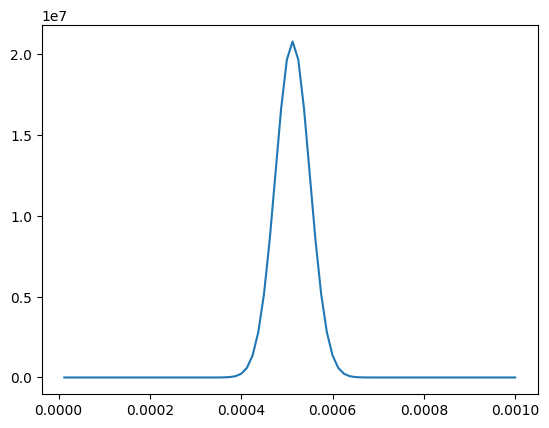

In [210]:
Xk = r[40]
df = delta_function(Xk, r)
plt.plot(r, df)

In [99]:
h = solution.y[:, 8]
# detect contact line
contact_line = np.argmax(h < 1e-6)
contact_line

46

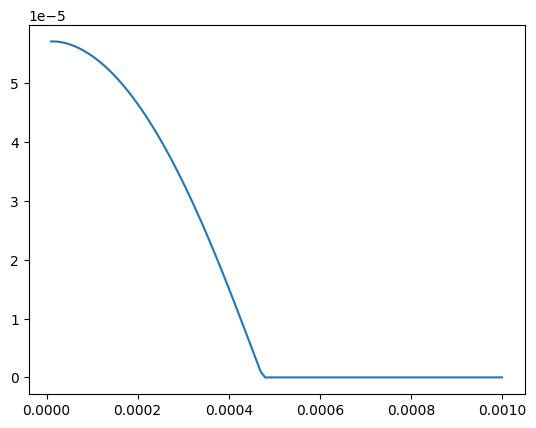

In [100]:
plt.plot(r, solution.y[:, 8])

## 1 Simplest Reynolds equation

Let's start from the simplest form: the Reynolds equation.

In [11]:
theta_s

286.4788975654116

0.0 0.0002 -0.0
1.7514502365162288e-08 0.00020000003379036928 -0.0
0.0 0.0002 -0.0
0.0 0.00020000000298023225 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0.0002 -0.0
0.0 0

Text(0, 0.5, 'Total Volume, $V$ (m$^3$)')

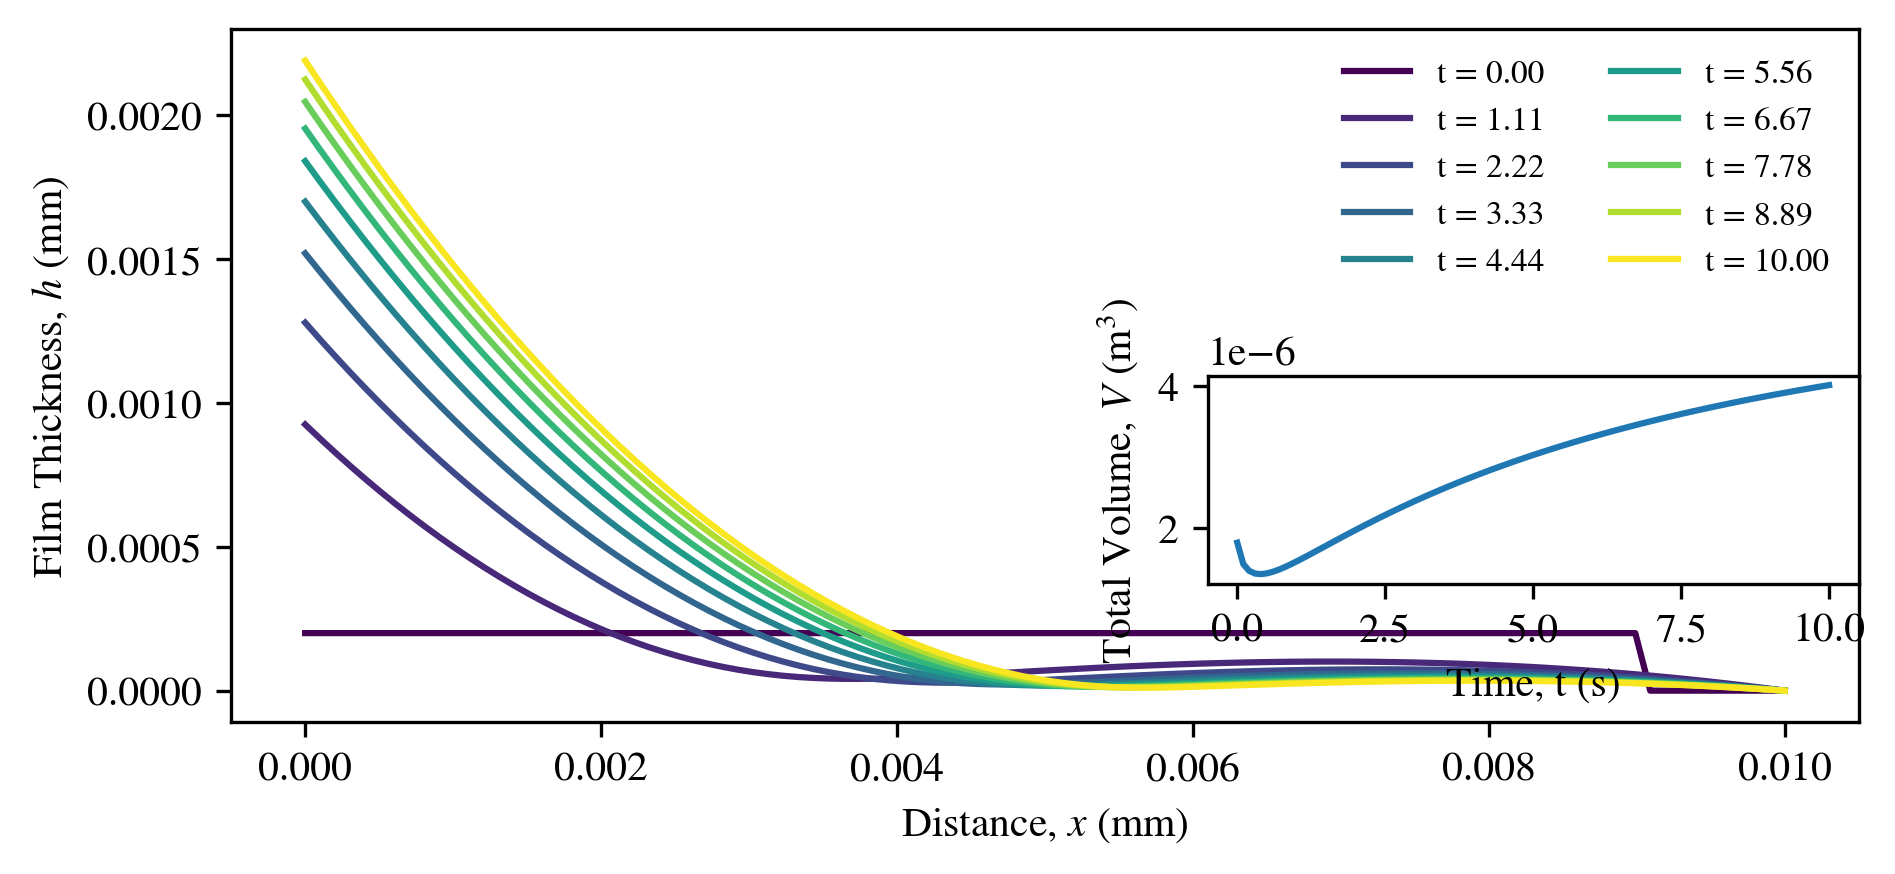

In [80]:
# Physical
sigma = 0.072  # Surface tension (N/m)
mu = 0.001    # Viscosity (Pa.s)
rho = 997     # Density of water (kg/m^3)
g = 9.8       # Gravitational acceleration (m/s^2)
theta_s = np.deg2rad(50) # Equilibrium contact angle (degrees)

# simulation
T = 10  # Total simulation time (s)
X = 1e-2        # Radius of the domain (m)
N = 100     # Number of radial grid points
x = np.linspace(0, X, N)  # Radial coordinate

# Initial condition
h0 = np.zeros_like(x)  # Initial film thickness profile
h0[:90] = 2e-4

# to debug
h_list = []

def film_drainage(t, y, x, X, rho, g, mu, sigma, theta_s):

    h = y
    # h_list.append(h)
    dx = (x[2:] - x[:-2]) / 2
    
    p = YL_equation(h, x, sigma)
    
    dhdt = np.zeros(h.shape)
    h3 =  h**3
    dhdt[1:-1] = 1 / (12 * mu) * ((h3[2:] - h3[:-2]) * (p[2:] - p[:-2]) + 4 * h3[1:-1] * (p[2:] - 2 * p[1:-1] + p[:-2])) / dx**2
    dhdt[-1] = 0

    U_cl = contact_line_velocity(h, x, sigma, mu, theta_s)
    print(t, h[0], p[-2])
    dhdt[0] = U_cl

    return dhdt

def YL_equation(h, x, sigma):
    dx = (x[2:] - x[:-2]) / 2
    p = np.zeros_like(h)
    p[1:-1] = - sigma * (h[2:] - 2 * h[1:-1] + h[:-2]) / dx**2
    p[0] = -10
    p[-1] = p[-2]
    return p

def contact_line_velocity(h, x, sigma, mu, theta_s, kappa=1e-5):
    """
    The contact line motion model of Kim et al. (2017)
    """
    theta = compute_contact_angle_0(h, x)
    # print(theta)
    U_cl = kappa / mu * sigma * theta * (theta**2 - theta_s**2)
    return U_cl

def compute_contact_angle_0(h, x):
    """
    Calculate the contact angle based on the film thickness profile
    """
    dh = h[2] - h[0]
    dx = x[2] - x[0]

    if dh == 0:
        return np.pi / 2
    else:
        angle = - np.arctan(dx / dh)
        if angle < 0:
            angle += np.pi
        return angle

# Solve the PDE using solve_ivp with the BDF method
t_eval = np.linspace(0, T, 100)
solution = solve_ivp(film_drainage, [0, T], h0, method='BDF', t_eval=t_eval, args=(x, X, rho, g, mu, sigma, theta_s), atol=1e-9, rtol=1e-9)  # BDF method is suitable for stiff problems

# Debugging information
print(f"Number of time steps in solution: {solution.y.shape[1]}")
print(f"Expected number of time steps: {len(t_eval)}")
print(f"Solver message: {solution.message}")

# Check if the solution has the expected number of time steps
if solution.y.shape[1] != len(t_eval):
    raise ValueError(f"Expected {len(t_eval)} time steps, but got {solution.y.shape[1]}")

# Plot the film thickness profile at multiple time steps on the same axis
time_steps = np.linspace(0, len(t_eval)-1, 10, dtype=int) # Indices of the time steps to visualize
fig, ax = plt.subplots(figsize=(7, 3), dpi=300)
cmap = plt.get_cmap('viridis')
for i in time_steps:
    ax.plot(x, solution.y[:, i], color=cmap(i/len(t_eval)), label=f't = {t_eval[i]:.2f}')

ax.set_xlabel('Distance, $x$ (mm)')
ax.set_ylabel('Film Thickness, $h$ (mm)')
ax.legend(frameon=False, loc='upper right', ncol=2, fontsize=8)

# Compute the total liquid volume over time
total_volume = np.trapz(solution.y[1:-1], x[1:-1], axis=0)

# plot total volume in inset
axins = ax.inset_axes([0.6, 0.2, 0.4, 0.3])
axins.plot(t_eval, total_volume)
axins.set_xlabel('Time, t (s)')
axins.set_ylabel('Total Volume, $V$ (m$^3$)')

In [55]:
theta_s

0.8726646259971648

In [40]:
h = solution.y[:, -1]
a = compute_contact_angle_0(h, x)
a

1.414727285587034